In [2]:
import pandas as pd
import numpy as np
from igraph import Graph

## Obtain Communities

In [3]:
# Function to obatain fastgreedy communities
def get_fastgreedy_communities(net):
    g = Graph.Load(net)
    dendrogram = g.community_fastgreedy(weights="weight")
    clusters = dendrogram.as_clustering()
    return g, clusters

In [4]:
# Build dataframe communities
def format_communities(g, clusters):
    
    def check_seller_role(row):
        if '_seller' in row['club_name']:
            row['club_name'] = row['club_name'].replace('_seller', '')
            row['role'] = 'seller'
        else:
            row['role'] = 'buyer'
        return row
    
    df_clusters = pd.DataFrame()
    for i, cluster in enumerate(clusters):
        cluster_idx = [i for c in cluster]
        club_name = [g.vs[c]["name"] for c in cluster]
        df_aux = pd.DataFrame({'cluster_idx': cluster_idx, 'club_name': club_name})
        df_clusters = pd.concat([df_clusters, df_aux])
    
    # Add league information
    df_league = pd.read_csv('resources_old_v2/club_league_v2.csv')
    df_league_sellers = df_league.copy()
    df_league_sellers['club_name'] = df_league_sellers['club_name'] + '_seller'
    df_clusters = pd.merge(df_clusters, df_league, how='left', on='club_name')
    df_clusters = pd.merge(df_clusters, df_league_sellers, how='left', on='club_name')
    df_clusters['league_name'] = df_clusters['league_name_x'].fillna(df_clusters['league_name_y'])
    df_clusters.drop(columns=['league_name_x', 'league_name_y'], inplace=True)
    
    df_clusters = df_clusters.apply(check_seller_role, axis=1)
    return df_clusters

In [100]:
# Get cluster's league composition
def get_league_composition(df_clusters):
    df_clusters_stats = df_clusters.groupby(['cluster_idx', 'role','league_name']).club_name.count().reset_index()
    df_clusters_stats_aux = df_clusters_stats.groupby(['cluster_idx', 'role']).club_name.sum().reset_index()
    df_clusters_stats = pd.merge(df_clusters_stats, df_clusters_stats_aux, how='inner', on=['cluster_idx', 'role'])
    df_clusters_stats.rename(columns={'club_name_x': 'count_league'}, inplace=True)
    df_clusters_stats['perc'] = 100*df_clusters_stats['count_league']/df_clusters_stats['club_name_y']
    df_clusters_stats.drop(columns='club_name_y', inplace=True)
    return df_clusters_stats

In [103]:
def filter_small_clusters(df_cluster_stats, min_clubs):
    df_cluster_stats_aux = df_cluster_stats[df_cluster_stats['role'] == 'buyer'].groupby('cluster_idx').count_league.sum().reset_index()
    df_cluster_stats_aux = df_cluster_stats_aux[df_cluster_stats_aux['count_league'] >= min_clubs]
    df_cluster_stats = pd.merge(df_cluster_stats, df_cluster_stats_aux[['cluster_idx']], how='inner', on='cluster_idx')
    return df_cluster_stats

In [89]:
# Do all function
def get_communities(net):
    g, clusters = get_fastgreedy_communities(net)
    df_clusters = format_communities(g, clusters)
    df_cluster_stats = get_league_composition(df_clusters)
    df_cluster_stats = filter_small_clusters(df_cluster_stats, 8)
    return df_clusters, df_cluster_stats

In [216]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import cm

cdict = {'Premier League': 'royalblue', 'Primera Division': 'forestgreen', 'Serie A': 'orange', '1 Bundesliga': 'red',
         'Ligue 1': 'hotpink', 'Liga Nos': 'peachpuff', 'Eredivisie': 'gold', 'Premier Liga': 'cornflowerblue',
         'Austria': 'darkseagreen', 'Belgium': 'mediumorchid', 'Argentina': 'deepskyblue', 'Brazil': 'yellow',
         'Chile': 'lightsalmon', 'Croatia': 'pink', 'Denmark': 'lightcyan', 'Greece': 'aqua', 'Hungary': 'olive',
         'Mexico': 'yellowgreen', 'Norway': 'silver', 'Polonia': 'linen', 'Romania': 'navajowhite',
         'Scotland': 'lavender', 'Serbia': 'maroon', 'Sweden': 'cornsilk', 'Switzerland': 'honeydew',
         'Turkey': 'tan', 'Ukraine': 'mintcream', 'Uruguay': 'powderblue', 'Usa': 'dimgrey', 'Other': 'black'}

def get_pie_chart_data(df_cluster_stats, cluster, role):
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    labels = df_cluster_stats[(df_cluster_stats['cluster_idx'] == cluster) &
                              (df_cluster_stats['role'] == role)]['league_name'].unique().tolist()
    sizes = df_cluster_stats[(df_cluster_stats['cluster_idx'] == cluster) &
                             (df_cluster_stats['role'] == role)]['perc'].tolist()
    
    # Obtain explode slice
    max_size_idx = sizes.index(max(sizes))
    aux = np.zeros(len(sizes))
    aux[max_size_idx] = 0.1
    explode = tuple(list(aux))
    
    return labels, sizes, explode

def get_pie_chart_plot(df_cluster, df_cluster_stats):
    cluster_list = df_cluster_stats['cluster_idx'].unique().tolist()
    num_clusters = len(cluster_list)
    fig, ax = plt.subplots(num_clusters, 2, figsize=(15, 75))
    
    j = 0
    for i in range(max(cluster_list)+1):
        if i not in cluster_list:
            continue
        # Get pie chart values
        labels_buyer, sizes_buyer, explode_buyer = get_pie_chart_data(df_cluster_stats, i, 'buyer')
        labels_seller, sizes_seller, explode_seller = get_pie_chart_data(df_cluster_stats, i, 'seller')
        # Get pie chart colors
        colors_buyer = [cdict[x] for x in labels_buyer]
        colors_seller = [cdict[x] for x in labels_seller]

        ax[j, 0].pie(sizes_buyer, explode=explode_buyer, labels=labels_buyer, autopct='%1.1f%%',
                     shadow=True, startangle=90, colors=colors_buyer)
        ax[j, 0].axis('equal')
        ax[j, 0].set_title('Cluster {} Buyers - League Proportion'.format(i), fontweight='bold')
        
        ax[j, 1].pie(sizes_seller, explode=explode_seller, labels=labels_seller, autopct='%1.1f%%',
                     shadow=True, startangle=90, colors=colors_seller)
        ax[j, 1].axis('equal')
        ax[j, 1].set_title('Cluster {} Sellers - League Proportion'.format(i), fontweight='bold')
        
        buyer_clubs = df_cluster[(df_cluster['cluster_idx'] == i) 
                          & (df_cluster['role'] == 'buyer')]['club_name'].unique().tolist()
        txt = ''
        for z, club in enumerate(buyer_clubs):
            if z % 10 == True:
                txt += club + '\n'
            else:
                txt += club + ', '
                
        ax[j, 0].text(0,-0.15,'Cluster Buyers {}: {}\n'.format(i, txt),transform=ax[j, 0].transAxes)
        
        j += 1
    
    plt.show()

## Community Analysis

### Bosman ruling

#### Pre Bosman era (1992-1995)

In [214]:
net = 'nets/1992-1995/freq_net.net'
df_cluster, df_cluster_stats = get_communities(net)

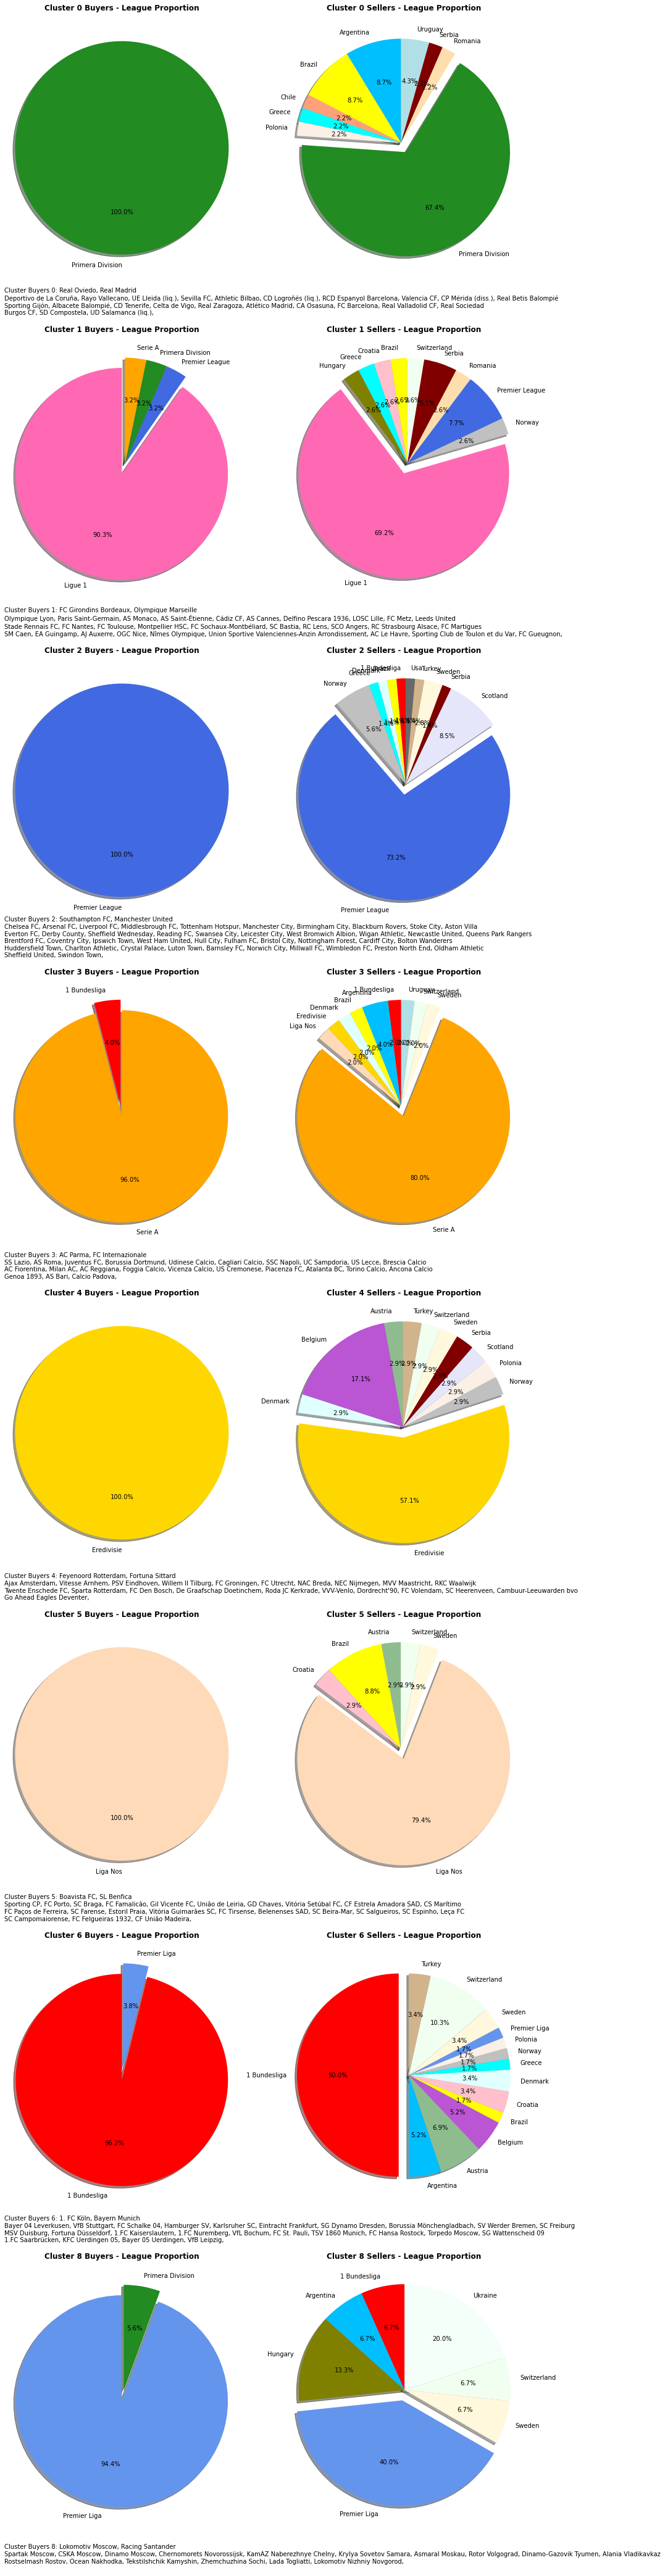

In [217]:
get_pie_chart_plot(df_cluster, df_cluster_stats)

__Comments__:

In the Pre-Bosman Era almost every cluster is represented by a different league, being the buyers and sellers teams in most of the cases from the same league. 

__Cluster 0__: La Liga Cluster. All spanish giants (FC Barcelona, Real Madrid, Atlético and Valencia) are in the same community. Despite the restrictions, there is already a clear tendency on how the Spanish league is an attractive destination for South American players, as almost 25% of the seller teams are from Latam. It is likely that sharing the language makes a difference when it comes to the clubs from Argentina, Uruguay and Chile.

__Cluster 1__: Ligue 1 Cluster. In the seller clubs there is a great majority of french teams and some weird cases of non big european teams (Pescara, Cadiz, Leeds United). It is clear the difference with the Spanish cluster in the case of the sellers: great majority of the national league and the rest is a combination of different european leagues, with very little importance of Latam teams (only 2.6%).

__Cluster 2__: Premier League Cluster. All the english big six (Manchester United, Manchester City, Chelsea, Arsenal, Liverpool, Tottenham - although City and Chelsea were not giants at that point) is in the community. Super british seller proportion with 73.2% Premier + 8.5% Scotland teams. Residual presence of south american teams.

__Cluster 3__: Serie A Cluster. Borussia Dortmund likes to buy in Italy, in the 90's they were known to bring back the best German players that went to play in Italy: indeed at that moment Serie A was the strongest league in the world. More presence of south american teams in the community (but not a lot) - connexion Italy-Argentina.

__Cluster 4__: Eredivisie Cluster. Not so dominant presence of netherlands teams in the seller club, which is compensated with the great amount of teams from Belgium (makes sense: neighbour countries). No latam teams.

__Cluster 5__: Liga Nos (Portugal) Cluster. Very local market. As it happened with La Liga and spanish-speaking south american leagues, notorious presence of Brazil in the market.

__Cluster 6__: Bundesliga. The more heterogeneous of the big leagues. Very european market (only 7% of latam teams) but not from the big leagues (no Ligue1, no La liga, no Serie A, no Premier League). 

__Cluster 7__: Russian Cluster. URSS disappeared a year before. Super important presence of eastern europe teams in the market (20% Ukraine, 13% Hungary). As a funny comment, Racing Santander is in the buyers group of clubs, which makes sense as in the beginning of 90's the team was known as "El Racing de los rusos" due to the presence of several russian players in the team.

#### Post Bosman era (1996+)

##### Early era 1996-1999

In [220]:
net = 'nets/1996-1999/freq_net.net'
df_cluster, df_cluster_stats = get_communities(net)

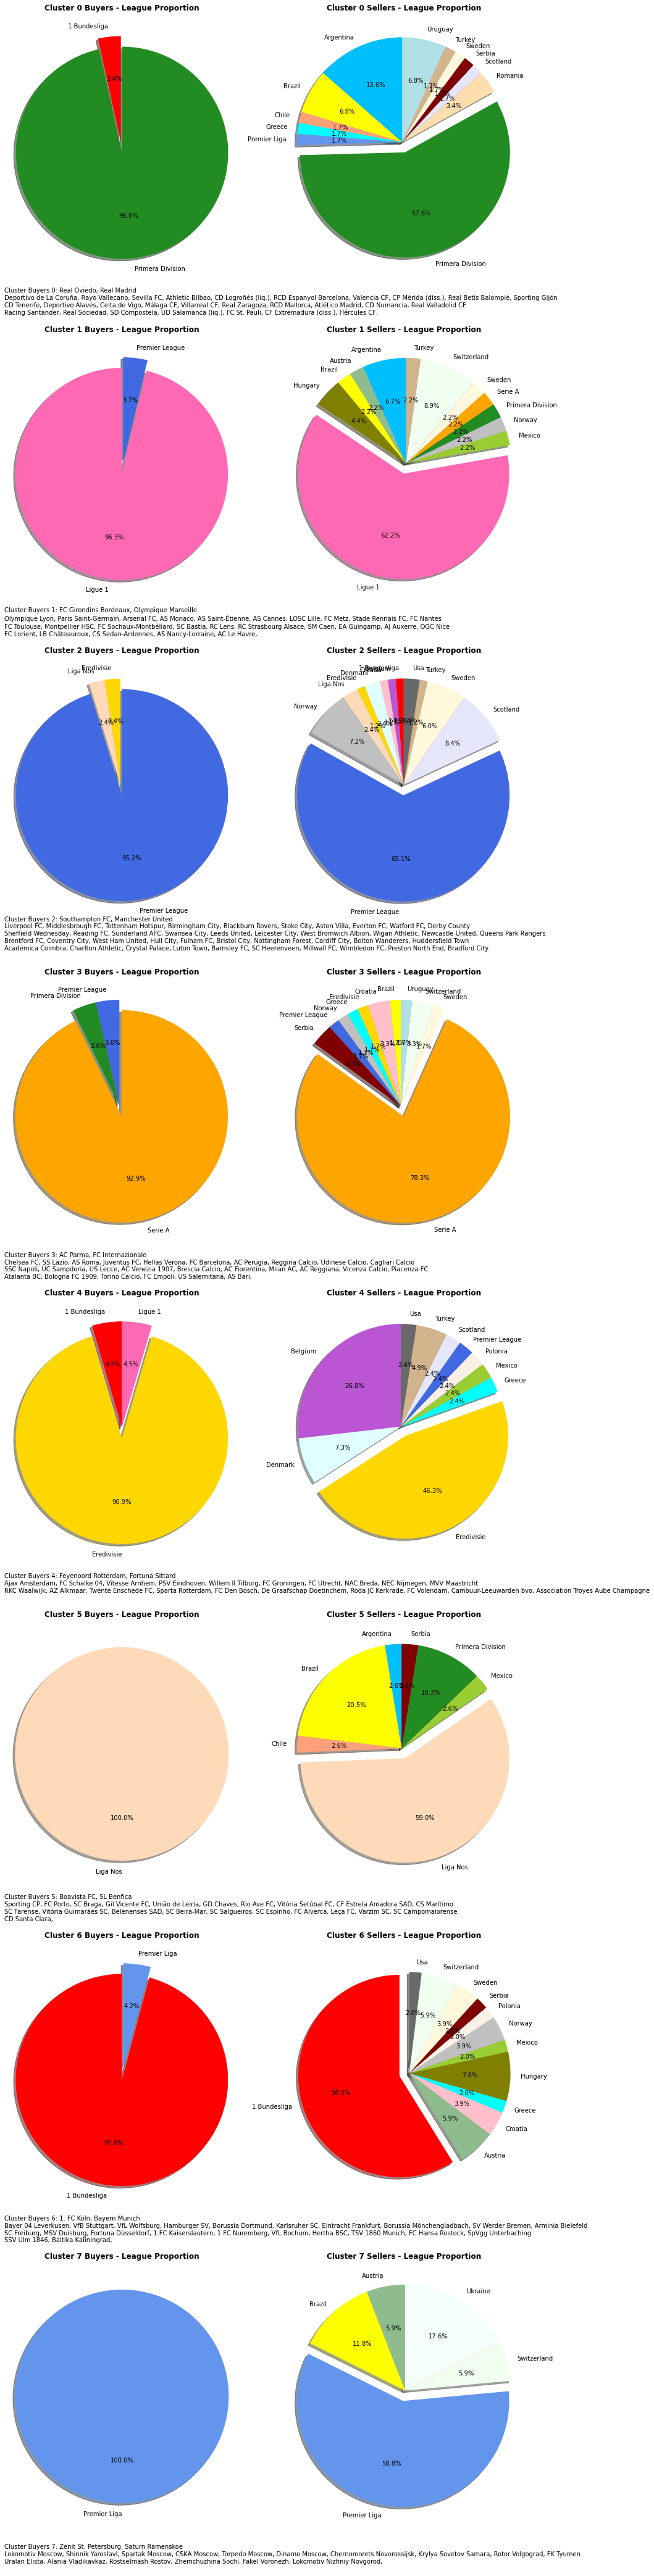

In [221]:
get_pie_chart_plot(df_cluster, df_cluster_stats)

__Comments__:
    
In the first years of the new ruling, there is a noticeable change in the structure of the communities (being more global) but still the tendency remains to be pretty much the same, with a great amount of local market. Interestingly, the rule despite apply to european players, also has an effect in some markets for the South American teams. This happens because as more european nationalities are allowed without counting as a foreign player, there is more room from south american players in the teams.

__Cluster 0__: La Liga cluster. There is one german team (St Pauli) but it does not look relevant. It is more relevant the absence of FC Barcelona in the cluster. The proportion of spanish teams in the seller part is reduced (10pp), lead by a increase of south american teams (29% vs 24% before) and the presence of more European leagues than before (but not top ones)

__Cluster 1__: Ligue 1 cluster. The presence of french teams in the seller part decreases (7pp) but the proportions keep quite constant (with more presence of teams from Argentina). It is curious how the community includes Arsenal FC in the buyers part. This makes completely sense as Arsene Wenger joined Arsenal at 1996, bringing with him a great amount of French players.

__Cluster 2__: Premier League cluster. Similar pattern in the english community - the majority of local market + scottish has decreased 8pp. Interesting to see the notoriety of northern european leagues (Norway & Sweden - 13%) in the communith. Arsenal and Chelsea are no longer in the english market community.

__Cluster 3__: Serie A cluster. It was the golden days for Serie A and therefore their teams didn't need to buy from outside of their league (remains as a mostly Italian community). It is interesting to see how teams like Barcelona (that was desperate to improve the team after the ridicolous lose against Milan in 1994 CL final) appears as a buyer in the community. Also Chelsea (that was not still a dominant club) appear there.

__Cluster 4__: Eredivisie cluster. First league where the local market is not the majority. Interesting to see the heavy proportion of teams from Belgium (same nationality as Bosman) in the seller part.

__Cluster 5__: Liga Nos. Heavy change in the community structure (local market losing 20pp). The presence of Brazilean teams in the seller part increases heavily (from 9 to 20%). Also important presence of Spanish teams as a market to buy for the portuguese teams.

__Cluster 6__: Bundesliga. Follows an opposite tendency from the rest of top leagues - is the only one where the local market proportion increases (almost 9pp). None of their giants (Bayern, Dortmund) left the community.

__Cluster 7__: Rusian league. Proportion of local market increases. Is a league not affected by Bosman ruling as it is not part of the european community. Interesting to see the increase of Brazilian market.

##### Mature era 2000 - 2010

In [222]:
net = 'nets/2000-2004/freq_net.net'
df_cluster, df_cluster_stats = get_communities(net)

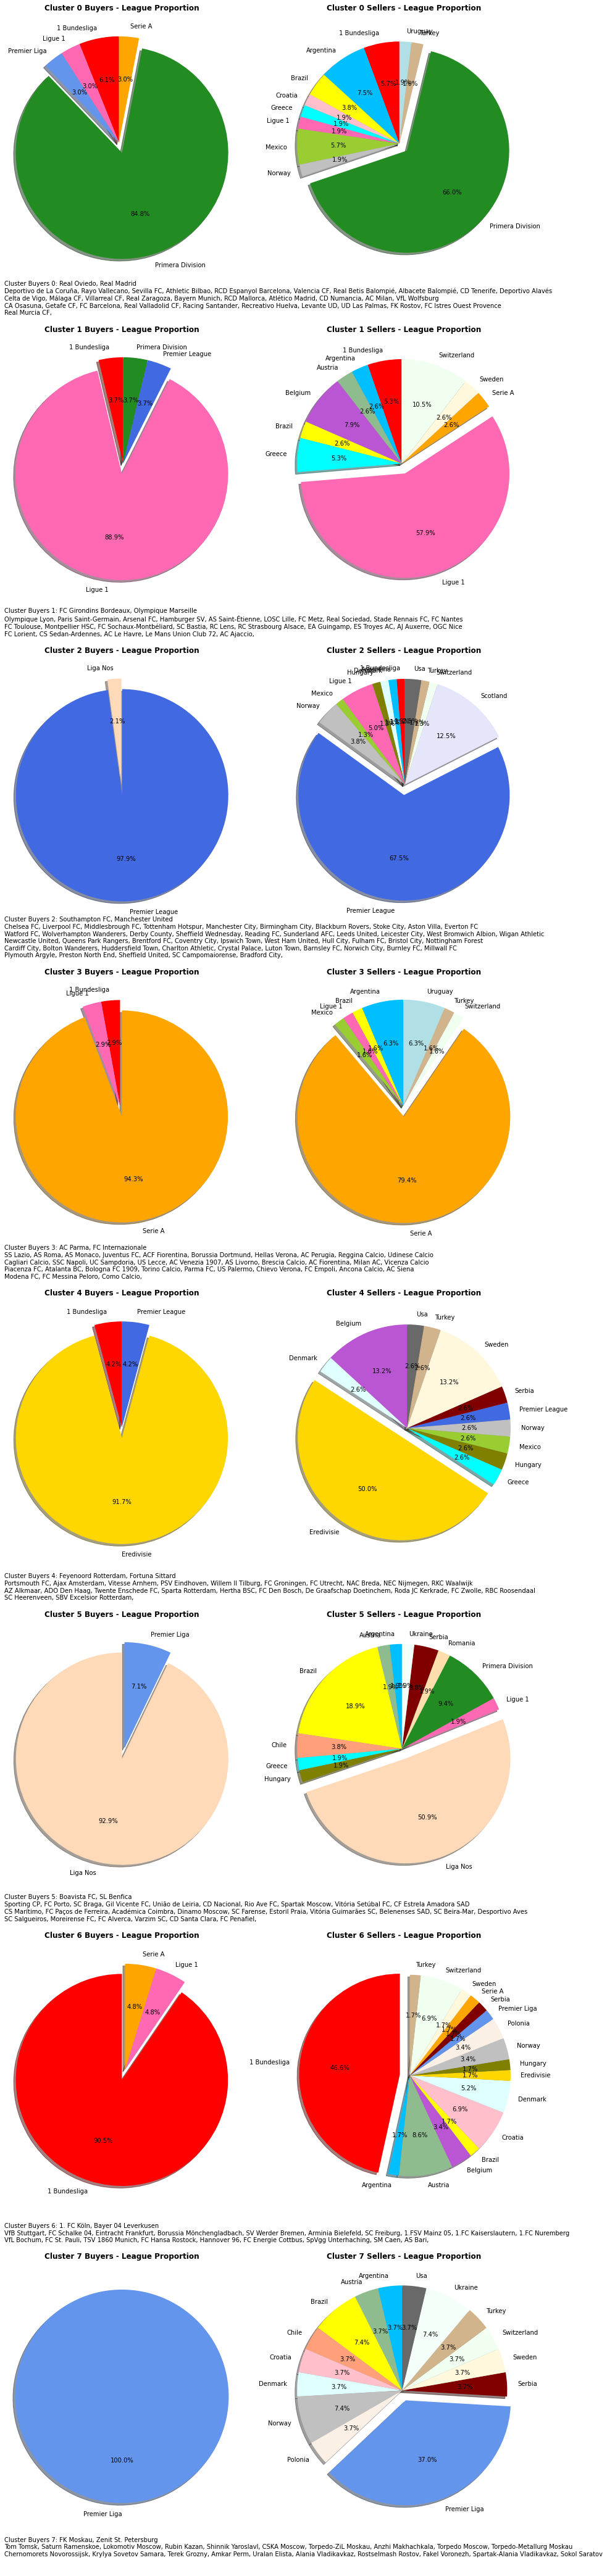

In [223]:
get_pie_chart_plot(df_cluster, df_cluster_stats)

__Comments__



In [224]:
net = 'nets/2005-2010/freq_net.net'
df_cluster, df_cluster_stats = get_communities(net)

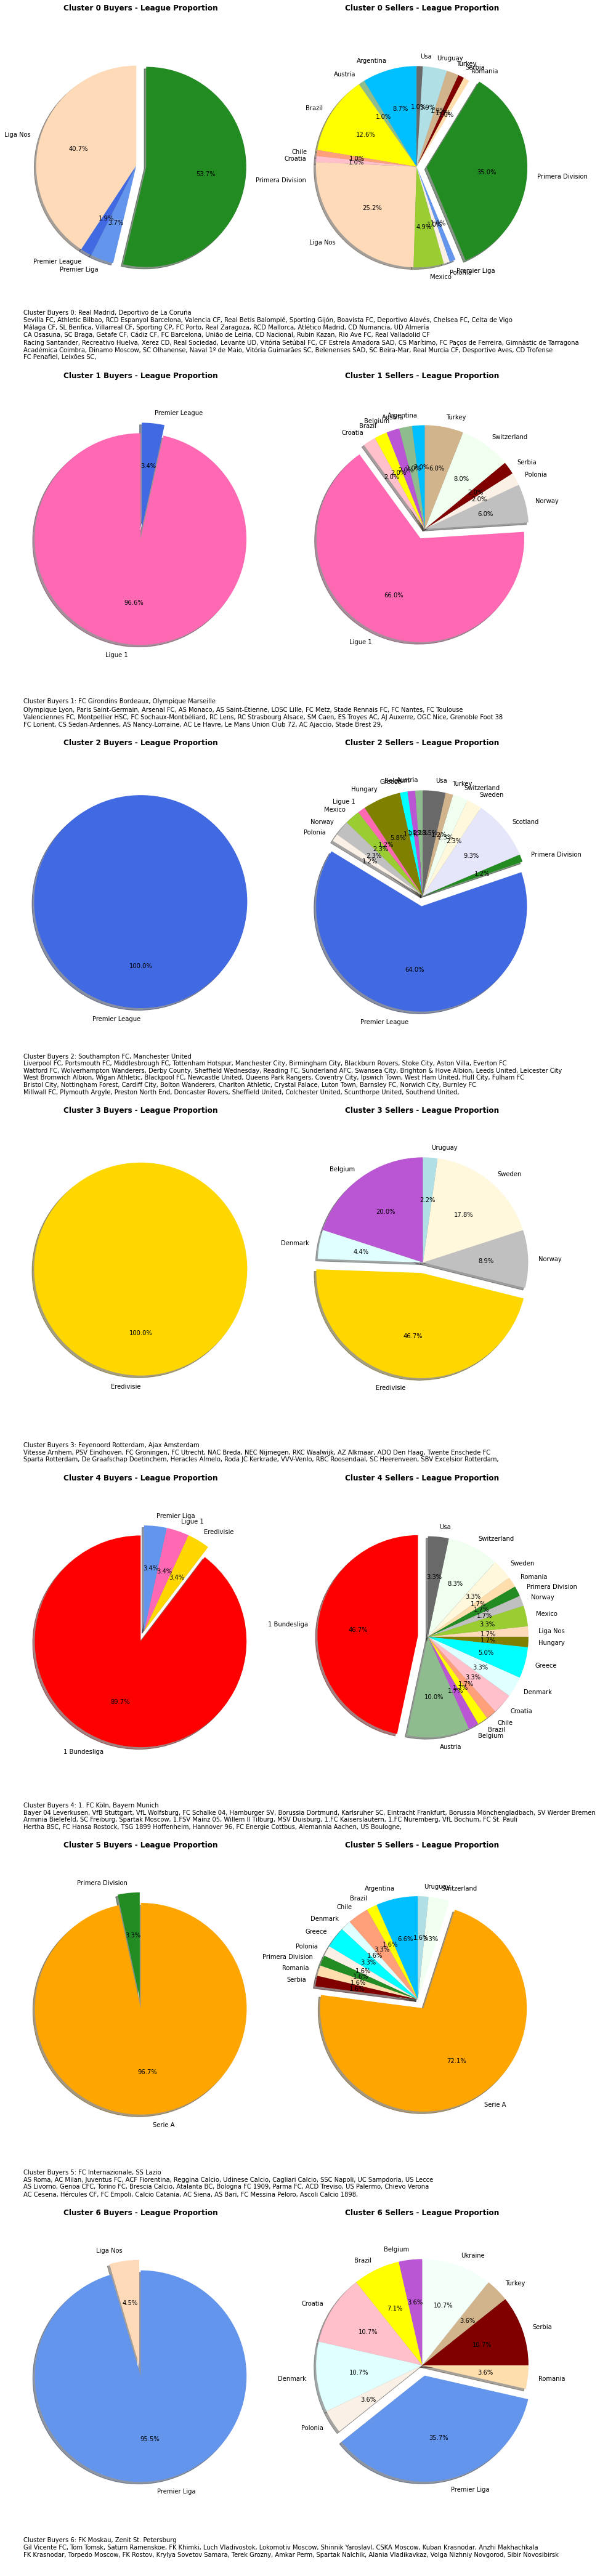

In [225]:
get_pie_chart_plot(df_cluster, df_cluster_stats)

##### Current Situation 2015-2020

In [226]:
net = 'nets/2015-2020/freq_net.net'
df_cluster, df_cluster_stats = get_communities(net)

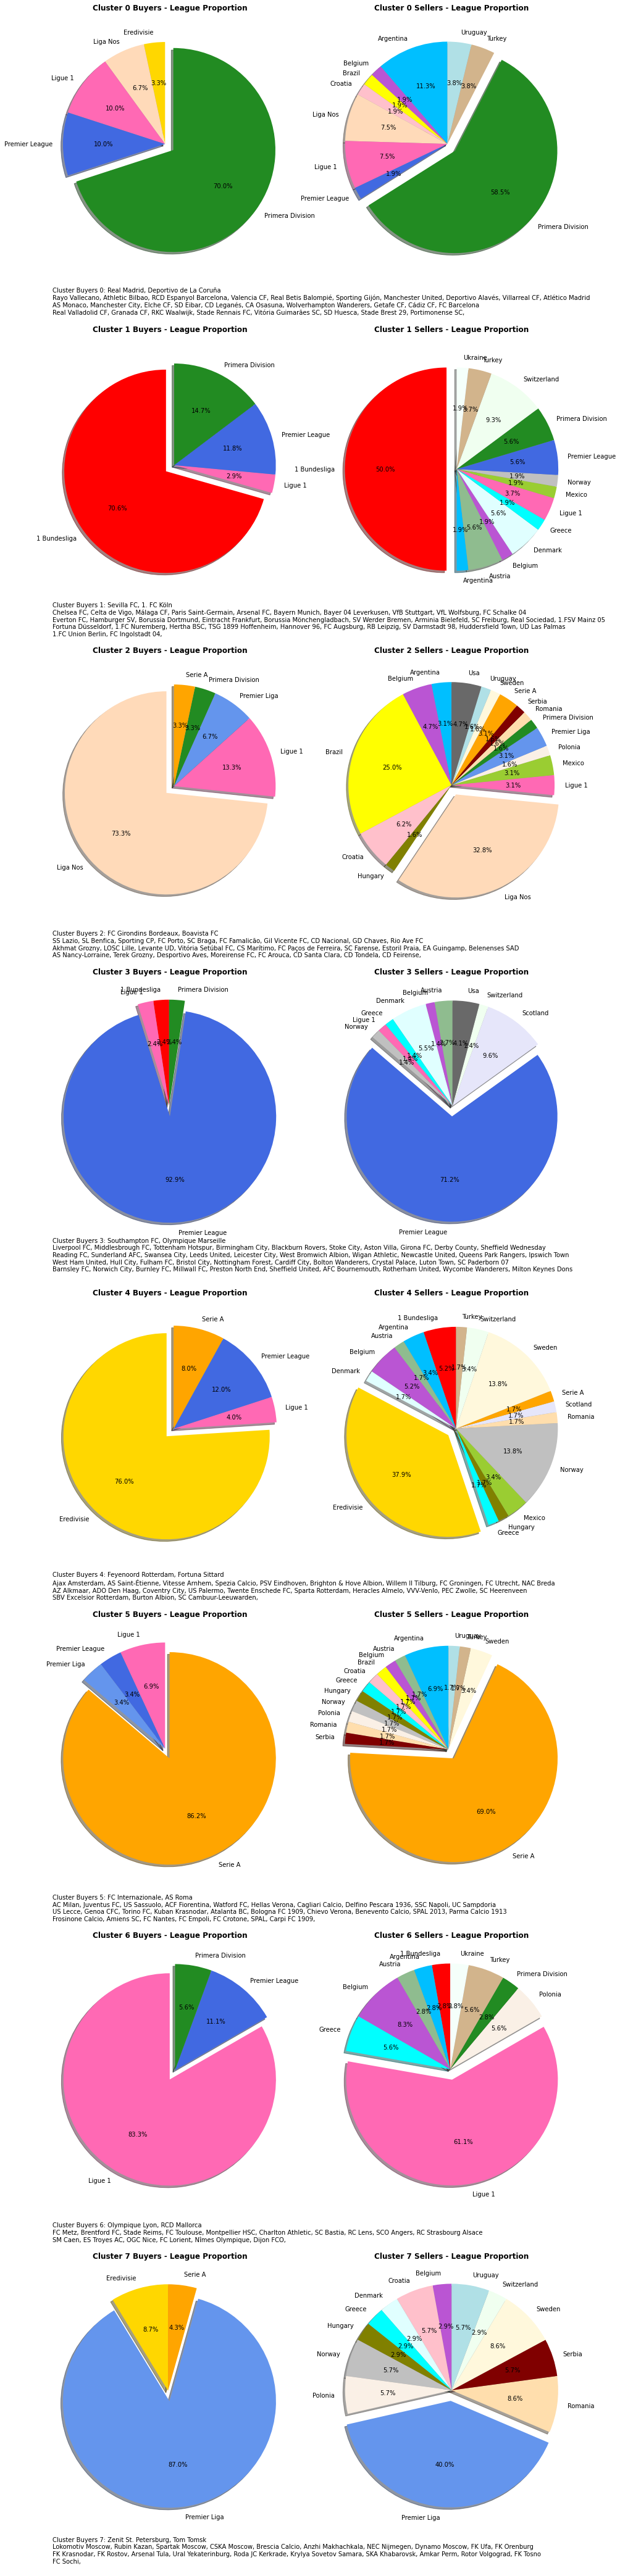

In [227]:
get_pie_chart_plot(df_cluster, df_cluster_stats)

Comments: Heterogeneous markets mostly due to big temas leaving their local markets. For most of the small teams the market keeps being local

In [228]:
net = 'nets/2015-2020/fee_net.net'
df_cluster, df_cluster_stats = get_communities(net)

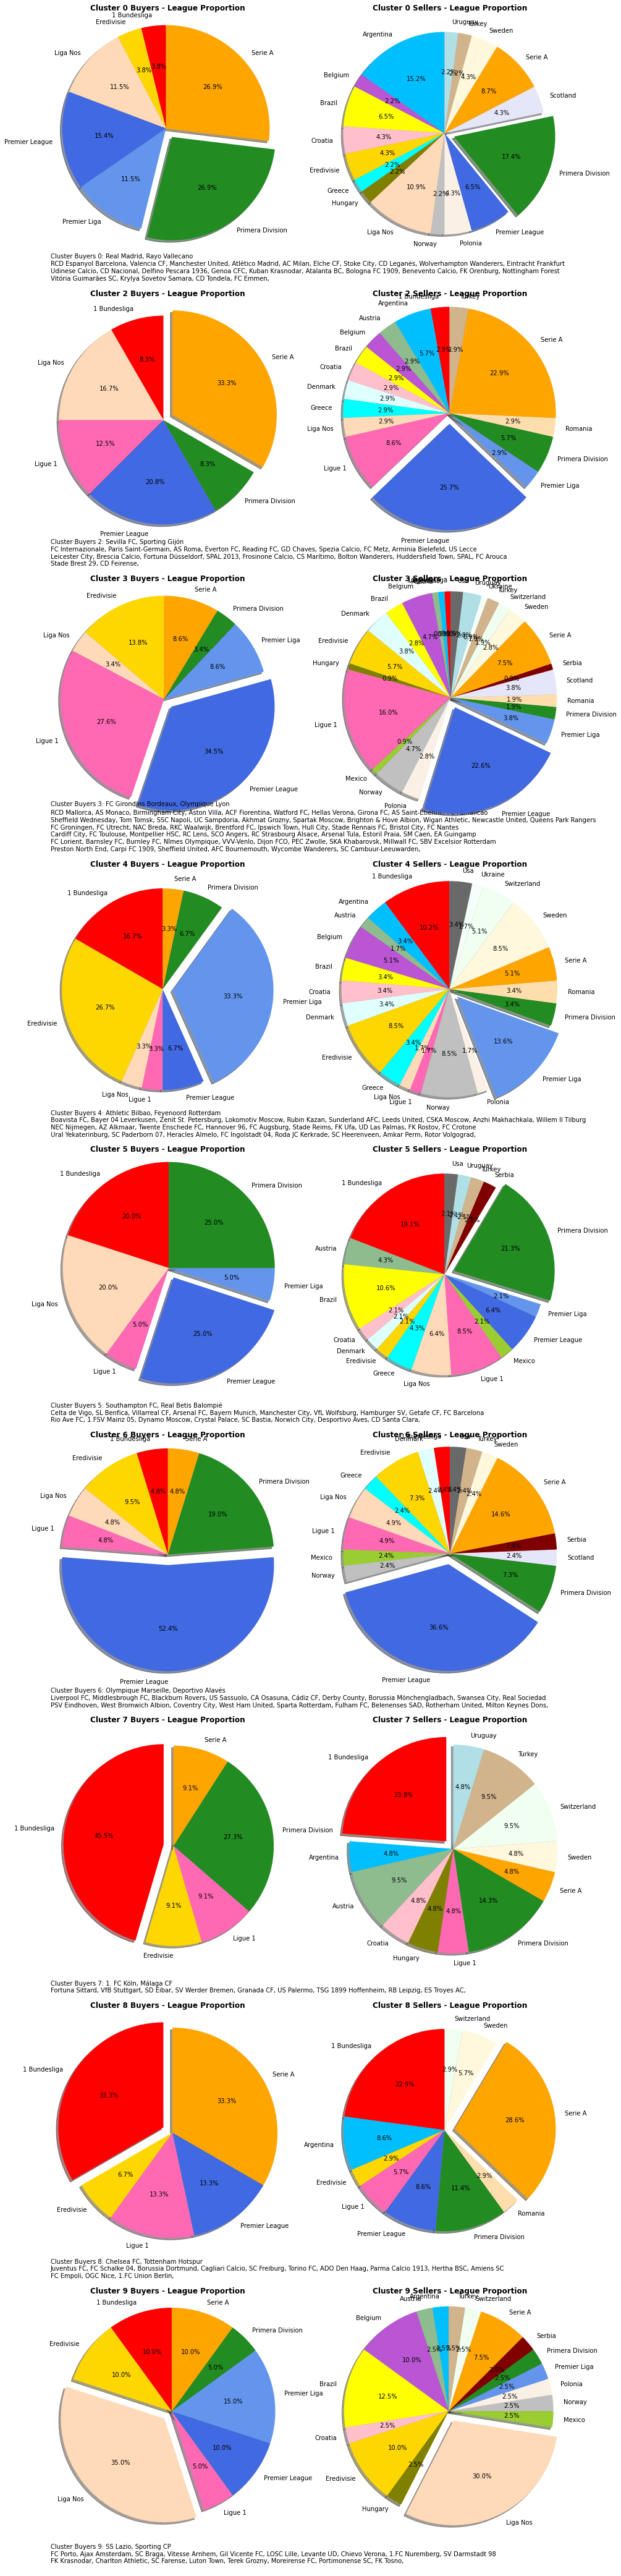

In [229]:
get_pie_chart_plot(df_cluster, df_cluster_stats)

When using fee_net the concept of national clusters (one per each league) is completely lost - say hi to completely heterogeneous communities

## Super League Analysis

__GOAL:__ Use Super League teams (the european economical ellite of clubs) to show how the communities obtained completely vary if the weighting criteria is based on the total amount of transfers between clubs or the total money spend in these transactions

__Intuition:__ For the biggest clubs it is convenient to use their national leagues to do most of their signings (easier negotiations + similar culture + players that dream to play in their national leagues + usually less expensive transfers) but they trade among themselves (internatinal markets) when they want to buy more exclusive and expensive players. In the end the big amounts of money are always in the hands of the same clubs.

In [193]:
net_freq = 'nets/2015-2020/freq_net.net'
df_cluster_freq, df_cluster_stats_freq = get_communities(net_freq)

net_fee = 'nets/2015-2020/fee_net.net'
df_cluster_fee, df_cluster_stats_fee = get_communities(net_fee)

In [135]:
def get_preferred_league(df_cluster, df_cluster_stats, team, role):
    cluster = df_cluster[(df_cluster['role'] == role) 
                               & (df_cluster['club_name'] == team)]['cluster_idx'].item()
    if role == 'buyer':
        df_aux = df_cluster_stats[(df_cluster_stats['cluster_idx'] == cluster) & (df_cluster_stats['role'] == 'seller')]
    else:
        df_aux = df_cluster_stats[(df_cluster_stats['cluster_idx'] == cluster) & (df_cluster_stats['role'] == 'buyer')]
    
    perc = df_aux['perc'].max()
    max_league = df_aux[df_aux['perc'] == perc]['league_name'].iloc[0]
    
    return '{} - {}%'.format(max_league, np.round(perc,2))
    

In [160]:
def get_sl_teams_in_cluster(df_cluster_sl, team):
    roles = ['buyer', 'seller']
    num_sl = []
    num_sl_same_league = []
    for role in roles:
        cluster = df_cluster_sl[(df_cluster_sl['role'] == role) 
                                   & (df_cluster_sl['club_name'] == team)]['cluster_idx'].item()
        league = df_cluster_sl[df_cluster_sl['club_name'] == team]['league_name'].iloc[0]
        num_sl_aux = df_cluster_sl[(df_cluster_sl['cluster_idx'] == cluster) 
                                   & (df_cluster_sl['is_super_league'] == 1)]['club_name'].unique().tolist()
        num_sl_same_league_aux = df_cluster_sl[(df_cluster_sl['cluster_idx'] == cluster) 
                                   & (df_cluster_sl['is_super_league'] == 1) 
                                   & (df_cluster_sl['league_name'] == league)]['club_name'].unique().tolist()
        num_sl = num_sl + num_sl_aux
        num_sl_same_league = num_sl_same_league + num_sl_same_league_aux
    
    num_sl = len(set(num_sl)) - 1
    perc_sl_same_league = np.round(100*(len(set(num_sl_same_league)) - 1)/num_sl, 2)
    
    return num_sl, perc_sl_same_league

In [206]:
def mask_sl(row):
    if row['is_super_league'] > 0:
        row['is_super_league'] = 1
    else:
        pass
    return row

def sl_in_clusters(df_cluster_sl):
    # Clean small clusters
    df_cluster_sl_aux = df_cluster_sl[df_cluster_sl['role'] == 'buyer'].groupby('cluster_idx').club_name.count().reset_index()
    df_cluster_sl_aux = df_cluster_sl_aux[df_cluster_sl_aux['club_name'] >= 8]
    df_cluster_sl = pd.merge(df_cluster_sl, df_cluster_sl_aux[['cluster_idx']], how='inner', on='cluster_idx')
    
    # Get if super league team in cluster + cluster size
    df_sl_in_cluster = df_cluster_sl.groupby('cluster_idx').is_super_league.sum().reset_index()
    df_els_in_cluster = df_cluster_sl.groupby('cluster_idx').club_name.count().reset_index()
    
    df_sl_in_cluster = pd.merge(df_sl_in_cluster, df_els_in_cluster, how='inner', on='cluster_idx')
    df_sl_in_cluster = df_sl_in_cluster.apply(mask_sl, axis=1)
    
    all_clubs = df_sl_in_cluster['club_name'].sum()
    df_sl_in_cluster['club_name'] = df_sl_in_cluster['club_name']/all_clubs
    
    # Rename columns
    df_sl_in_cluster.rename(columns={'is_super_league': 'has_super_league', 'club_name': 'cluster_weight'}, inplace=True)
    
    return df_sl_in_cluster

def get_perc_clusters_w_sl(df_sl_in_cluster):
    df_sl_in_cluster['product'] = df_sl_in_cluster['has_super_league']*df_sl_in_cluster['cluster_weight']
    return df_sl_in_cluster['product'].sum()

In [121]:
super_league_teams = ['Real Madrid', 'FC Barcelona', 'Atlético Madrid',
                      'Manchester United', 'Manchester City', 'Chelsea FC',
                      'Liverpool FC', 'Arsenal FC', 'Tottenham Hotspur',
                      'Juventus FC', 'AC Milan', 'FC Internazionale',
                      'Bayern Munich', 'Borussia Dortmund', 'Paris Saint-Germain']

### Super League Teams - Community perspective per team

In [194]:
df_sl_teams = pd.DataFrame(columns=['club_name'], data=super_league_teams)
df_sl_teams['is_super_league'] = 1

df_cluster_sl_freq = pd.merge(df_cluster_freq, df_sl_teams, how='left', on='club_name').fillna(0)
df_cluster_sl_fee = pd.merge(df_cluster_fee, df_sl_teams, how='left', on='club_name').fillna(0)

In [165]:
data = {'Super League Team':[], 'Majority Buyer League - Freq': [], 'Majority Seller League - Freq': [],
        'Majority Buyer League - Fee': [], 'Majority Seller League - Fee': []}
data_2 = {'Super League Team':[], '#SL Teams - Freq': [], '%SL Teams National League - Freq': [],
        '#SL Teams - Fee': [], '%SL Teams National League - Fee': []}
for team in super_league_teams:
    max_buyer_league_freq = get_preferred_league(df_cluster_freq, df_cluster_stats_freq, team, 'buyer')
    max_seller_league_freq = get_preferred_league(df_cluster_freq, df_cluster_stats_freq, team, 'seller')
    max_buyer_league_fee = get_preferred_league(df_cluster_fee, df_cluster_stats_fee, team, 'buyer')
    max_seller_league_fee = get_preferred_league(df_cluster_fee, df_cluster_stats_fee, team, 'seller')
    data['Super League Team'].append(team)
    data['Majority Buyer League - Freq'].append(max_buyer_league_freq)
    data['Majority Seller League - Freq'].append(max_seller_league_freq)
    data['Majority Buyer League - Fee'].append(max_buyer_league_fee)
    data['Majority Seller League - Fee'].append(max_seller_league_fee)
    
    num_sl_freq, num_sl_same_league_freq = get_sl_teams_in_cluster(df_cluster_sl_freq, team)
    num_sl_fee, num_sl_same_league_fee = get_sl_teams_in_cluster(df_cluster_sl_fee, team)
    data_2['Super League Team'].append(team)
    data_2['#SL Teams - Freq'].append(num_sl_freq)
    data_2['%SL Teams National League - Freq'].append(num_sl_same_league_freq)
    data_2['#SL Teams - Fee'].append(num_sl_fee)
    data_2['%SL Teams National League - Fee'].append(num_sl_same_league_fee)
    
    

#### Majority league in the Super League Team's communities

In this section it is analysed the majority league present in the communities where the Super League Teams are placed either as buyer or sellers.

The analysis is split when the network is frequency or fee based

In [166]:
df_sl = pd.DataFrame(data=data)
df_sl

Super League Team Majority Buyer League - Freq  \
0           Real Madrid    Primera Division - 58.49%   
1          FC Barcelona    Primera Division - 58.49%   
2       Atlético Madrid    Primera Division - 58.49%   
3     Manchester United    Primera Division - 58.49%   
4       Manchester City    Primera Division - 58.49%   
5            Chelsea FC         1 Bundesliga - 50.0%   
6          Liverpool FC      Premier League - 71.23%   
7            Arsenal FC         1 Bundesliga - 50.0%   
8     Tottenham Hotspur      Premier League - 71.23%   
9           Juventus FC             Serie A - 68.97%   
10             AC Milan             Serie A - 68.97%   
11    FC Internazionale             Serie A - 68.97%   
12        Bayern Munich         1 Bundesliga - 50.0%   
13    Borussia Dortmund         1 Bundesliga - 50.0%   
14  Paris Saint-Germain         1 Bundesliga - 50.0%   

   Majority Seller League - Freq Majority Buyer League - Fee  \
0          1 Bundesliga - 70.59%   Primera Division - 17.39%   
1          1 Bundesliga - 70.59%   Primera Division - 21.28%   
2       Primera Division - 70.0%   Primera Division - 17.39%   
3        Premier League - 92.86%   Primera Division - 17.39%   
4        Premier League - 92.86%   Primera Division - 21.28%   
5       Primera Division - 70.0%            Serie A - 28.57%   
6        Premier League - 92.86%     Premier League - 36.59%   
7          1 Bundesliga - 70.59%   Primera Division - 21.28%   
8        Premier League - 92.86%            Serie A - 28.57%   
9               Serie A - 86.21%            Serie A - 28.57%   
10              Serie A - 86.21%   Primera Division - 17.39%   
11              Serie A - 86.21%     Premier League - 25.71%   
12         1 Bundesliga - 70.59%   Primera Division - 21.28%   
13         1 Bundesliga - 70.59%            Serie A - 28.57%   
14             Liga Nos - 73.33%     Premier League - 25.71%   

   Majority Seller League - Fee  
0         1 Bundesliga - 33.33%  
1              Serie A - 33.33%  
2        Premier League - 25.0%  
3              Serie A - 33.33%  
4              Serie A - 33.33%  
5     Primera Division - 26.92%  
6        Premier League - 25.0%  
7       Premier League - 52.38%  
8        Premier League - 25.0%  
9     Primera Division - 26.92%  
10        1 Bundesliga - 33.33%  
11    Primera Division - 26.92%  
12        1 Bundesliga - 33.33%  
13       Premier League - 25.0%  
14        1 Bundesliga - 33.33%

__Comment__

It can be seen how the majority league of the cluster of the teams of the super league varies depending on the usage of frequency of transfers as weight or the total fee of the transfers. In some of the cases, the majority league keeps being the same but the % of the winner is clearly lower, which examplifies how the fee communitites are much more heterogeneous. It is also interesting to see how the Italian and German teams do much more transfers with communities of their national league but how this completely changes when the transfer fee is taken into consideration. The same happens to Tottenham Hotspur in England. Which means that 33% of the super league teams change from national to international market depending on the weighting criteria.

In general it can be seen how the tendency is to majority go to the national league to do the more frequent transfers (with the exception of most of the english teams -except Liverpool and Tottenham-) while looking for international markets when having to do the most expensive transfers, which explain the variability between the frequency and fee communitites.

#### Presence of other SL Teams in the SL Team's communities

In this section we check per each SL team, the number of other super league teams that are in the same cluster. 

The analysis is split when the network is frequency or fee based

In [167]:
df_sl_2 = pd.DataFrame(data=data_2)
df_sl_2

Super League Team  #SL Teams - Freq  %SL Teams National League - Freq  \
0           Real Madrid                 9                             22.22   
1          FC Barcelona                 9                             22.22   
2       Atlético Madrid                 5                             40.00   
3     Manchester United                 7                             57.14   
4       Manchester City                 7                             57.14   
5            Chelsea FC                 9                             33.33   
6          Liverpool FC                 3                            100.00   
7            Arsenal FC                 6                             16.67   
8     Tottenham Hotspur                 3                            100.00   
9           Juventus FC                 2                            100.00   
10             AC Milan                 2                            100.00   
11    FC Internazionale                 2                            100.00   
12        Bayern Munich                 6                             16.67   
13    Borussia Dortmund                 6                             16.67   
14  Paris Saint-Germain                 6                              0.00   

    #SL Teams - Fee  %SL Teams National League - Fee  
0                10                            10.00  
1                10                            10.00  
2                13                            15.38  
3                 9                            22.22  
4                10                            40.00  
5                10                            20.00  
6                 7                            42.86  
7                 7                            42.86  
8                12                            33.33  
9                10                            20.00  
10               10                            20.00  
11                9                            22.22  
12               12                             8.33  
13               12                             8.33  
14               11                             0.00

__Comment__

In this table it is analysed, per each of the teams, the number of Super League teams with whom they share cluster. The conclusions that can be extracted from this graph are similar to the previous table: there are some teams that clearly change their pattern depending on if the criteria is quantity based or fee based. A clear example of that are especially italian teams. All of them only share cluster with the other italian teams in the freq based communitites but this completely changes when checking it on a fee criteria. Again this examplifies how for the day to day transfers, which are not very expensive, they prefer to go to the national market, while when having to do the heavy investments they prefer to cluster with the elite of the teams of the continent. A similar patter happens with Bayern Munich, Borussia Dortmund and Paris Saint-Germain, which probably lack from important teams in their leagues to do this more expensive transfers, reason why they move to ellite communities to sign expensive players. Among the english teams, especially Tottenham and Liverpool are in a similar situation. On the other hand, the teams of Manchester or Arsenal present a more similar pattern in both types of communities, but in this case can be understood given the great amount of great teams in the Premier League, which may result in less necessity to go to international markets to invest money. Finally, there are 3 teams that clearly look like permanently installed in ellite clusters, regardless of the criteria that is used. These teams are Real Madrid, FC Barcelona and Chelsea FC. In the previous analysis it was seen how at least Barça and Madrid were in national communities, but in any case they are always together with some other elite teams, which also suggests how the Spanish League is an interesting market for the top european teams.

In general it can be concluded how most of the big teams don't usually trade together in terms of quantity of transfers but definetely do when the quantity analysed is of money: they are part of elitist economical communities that usually trade together when a lot of money is moved. In the end this looks like a loopy situation: these teams have more money, they can buy better players and when they trade this good players for a lot of money. only some other teams from the economical ellite can afford them, which results in the pattern observed in the data.

### Super League Teams - Aggregated Community perspective

In [201]:
df_sl_in_cluster_freq = sl_in_clusters(df_cluster_sl_freq)
df_sl_in_cluster_fee = sl_in_clusters(df_cluster_sl_fee)

In [202]:
df_sl_in_cluster_freq

cluster_idx  has_super_league  cluster_weight
0          0.0               1.0        0.125378
1          1.0               1.0        0.132931
2          2.0               1.0        0.141994
3          3.0               1.0        0.173716
4          4.0               0.0        0.125378
5          5.0               1.0        0.131420
6          6.0               0.0        0.081571
7          7.0               0.0        0.087613

In [203]:
df_sl_in_cluster_fee

cluster_idx  has_super_league  cluster_weight
0          0.0               1.0        0.109924
1          2.0               1.0        0.090076
2          3.0               0.0        0.250382
3          4.0               0.0        0.135878
4          5.0               1.0        0.102290
5          6.0               1.0        0.094656
6          7.0               0.0        0.048855
7          8.0               1.0        0.076336
8          9.0               0.0        0.091603

In [212]:
print('Percentage of clusters with SL teams - Freq: ', np.round(get_perc_clusters_w_sl(df_sl_in_cluster_freq), 2))
print('Percentage of clusters with SL teams - Fee: ', np.round(get_perc_clusters_w_sl(df_sl_in_cluster_fee), 2))

Percentage of clusters with SL teams - Freq:  0.71
Percentage of clusters with SL teams - Fee:  0.47


__Comment__

Interesting to see how when the frequencies networks, we obtain as many clusters as the total number of analysed leagues. On the other hand, when using fee, some extra small communities appear. It is also interesting to see the formation of ellite communities based on fee: it can be observed how the clusters weights are much less uniform (i.e. the number of teams in each cluster is pretty much the same when the analysis is based on frequency but is much more skewed if the fee is taken into consideration) and most importantly how the communities that have some Super League team in them are usually smaller, which reinforces this idea of having exclusive communities of the richest clubs. In that sense, the __Percentage of clusters with SL teams__ shown above is very clear: when using the frequency criteria more than 70% of the communities have at least one Super League Team. In this clustering scheme, the clusters are associated to a concrete league and usually the SL teams of that league use the national market to do most of their operations (even if they are not very expensive). On the other hand, __Percentage of clusters with SL teams__ goes down to 47% when using the fee criteria. This shows us how in terms of economic amount, not all the teams can be in the same community, because simply some of them cannot afford it. Thus, only less than half of the communities have SL teams on it. Which clearly draws an scenario where half of the teams are part of the "rich club" and the rest have to trade among themselves in the "poor club" party.